## Load Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from dipeptides.data import XYZData

cutoff = 4.0
edata = XYZData(batch_size=1,cutoff=cutoff)
atomic_nums = []
for batch in edata.val_dataloader():
    break
batch

/home/king1305/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/king1305/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Batch(atomic_numbers=[45], batch=[45], bec=[45, 9], cell=[3, 3], dipole=[1, 3], edge_index=[2, 718], energy=[1], force=[45, 3], hirsh_charges=[45], hirsh_dipole=[3], hirsh_quadrupole=[3, 3], mbi_charges=[45], mbi_dipole=[3], mbi_quadrupole=[3, 3], mul_charges=[45], mul_dipole=[3], mul_quadrupole=[3, 3], positions=[45, 3], pred_bec=[45, 9], pred_charges=[45], pred_dipole=[3], pred_quadrupole=[3, 3], ptr=[2], quadrupole=[1, 3, 3], shifts=[718, 3], unit_shifts=[718, 3])

## Load Model

In [3]:
#Losses
import torch
from cace.tasks import GetLoss
e_loss = GetLoss(
    target_name="energy",
    predict_name='pred_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1,
)
f_loss = GetLoss(
    target_name="force",
    predict_name='pred_force',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1000,
)
losses = [e_loss,f_loss]

#Metrics
from cace.tools import Metrics
e_metric = Metrics(
            target_name="energy",
            predict_name='pred_energy',
            name='e',
            metric_keys=["rmse"],
            per_atom=True,
        )
f_metric = Metrics(
            target_name="force",
            predict_name='pred_force',
            metric_keys=["rmse"],
            name='f',
        )
metrics = [e_metric,f_metric]

In [4]:
from cace.tasks import LightningData, LightningTrainingTask
from dipeptides.model import make_cace_lr

#LR model
lr_model = make_cace_lr(cutoff=cutoff,lr=True)
lr_model.cuda()
lr_model(batch.cuda())
lr_task = LightningTrainingTask(lr_model,losses=losses,metrics=metrics,
                             logs_directory="model_runs/lightning_logs",name="test",
                             scheduler_args={'mode': 'min', 'factor': 0.8, 'patience': 10},
                             optimizer_args={'lr': 0.01},
                            )
chkpt = "models/lr-model.ckpt"
lr_task.load(chkpt)
lr_task.model.cuda();

Loading model from models/lr-model.ckpt ...
Loading successful!


## Make Charges / BEC / Dipoles / Quads

In [21]:
#Generate charges for test and val sets
from dsk.pickle import load_pkl
import ase
import cace
import numpy

fac = (90.0474)**0.5
val_fn = "data/spice-dipep-dipolar_val.xyz"
test_fn = "data/spice-dipep-dipolar_test.xyz"

calc_polarization = cace.modules.polarization.Polarization(remove_mean=False)
calc_bec = cace.modules.grad.Grad(
    y_key = 'polarization',
    x_key = 'positions',
    output_key = 'bec'
)
def gen_q_bec(batch):
    batch.cuda()
    out = lr_task.model.model.forward(batch,training=True)
    batch["q"] = out["q"]
    batch = calc_polarization(batch)
    batch = calc_bec(batch)
    pred_bec = batch["bec"].cpu().detach().numpy()
    pred_q = (out["q"]/fac).cpu().detach().numpy()
    torch.cuda.empty_cache()
    return pred_q, pred_bec

#Generate for val
atms = []
for atm, batch in zip(ase.io.iread(val_fn),edata.val_dataloader()):
    pred_q, pred_bec = gen_q_bec(batch) 
    atm.arrays["pred_charges"] = pred_q
    atm.arrays["pred_bec"] = pred_bec.reshape(-1,9)
    atms += [atm]
ase.io.write(val_fn,atms)

# #Generate for test
atms = []
for atm, batch in zip(ase.io.iread(test_fn),edata.test_dataloader()):
    pred_q, pred_bec = gen_q_bec(batch) 
    atm.arrays["pred_charges"] = pred_q
    atm.arrays["pred_bec"] = pred_bec.reshape(-1,9)
    atms += [atm]
ase.io.write(test_fn,atms)

In [23]:
def calc_dipole_quad(positions,q):
    dip = (positions * q[:,None]).sum(axis=0)
    rij = positions[:,:,None] * positions[:,None,:]
    quad = (q.reshape(-1,1,1) * rij).sum(axis=0)
    eye = np.eye(3)
    quad = quad - 1/3 * quad.trace()*eye
    return dip, quad

#Calculate dipoles/quads for val
atms = []
for atm in ase.io.iread(val_fn):
    ks = [k for k in atm.arrays.keys() if "charges" in k]
    typs = [k.split("_")[0] for k in ks]
    positions = atm.arrays["positions"]
    for k in ks:
        q = atm.arrays[k]
        dip, quad = calc_dipole_quad(positions,q)
        typ = k.split("_")[0]
        atm.info[f"{typ}_dipole"] = dip
        atm.info[f"{typ}_quadrupole"] = quad
    atms += [atm]
ase.io.write(val_fn,atms)

#Calculate dipoles/quads for test
atms = []
for atm in ase.io.iread(test_fn):
    ks = [k for k in atm.arrays.keys() if "charges" in k]
    typs = [k.split("_")[0] for k in ks]
    positions = atm.arrays["positions"]
    for k in ks:
        q = atm.arrays[k]
        dip, quad = calc_dipole_quad(positions,q)
        typ = k.split("_")[0]
        atm.info[f"{typ}_dipole"] = dip
        atm.info[f"{typ}_quadrupole"] = quad
    atms += [atm]
ase.io.write(test_fn,atms)

## Make BEC

In [27]:
import cace
import pandas as pd
import numpy as np

def calc_bec()

#Takes a bit to run
class BEC():
    def __init__(self,remove_mean=False):
        model = lr_task.model.model
        model.cuda()

        #Remove_mean=False but can also do True, small difference
        polarization = cace.modules.polarization.Polarization(remove_mean=remove_mean)        
        bec = cace.modules.grad.Grad(
            y_key = 'polarization',
            x_key = 'positions',
            output_key = 'bec'
        )

        true_bec = []
        pred_bec = []
        for batch in edata.val_dataloader():
            batch_bec = batch["bec"].reshape(batch["bec"].shape[0],3,3)
            true_bec.append(batch_bec.cpu().detach().numpy())
            
            batch.cuda()
            out = model.forward(batch,training=True)
            batch["q"] = out["q"]
            batch = polarization(batch)
            batch = bec(batch)
            pred_bec.append(batch["bec"].cpu().detach().numpy())
            torch.cuda.empty_cache()

        self.true_bec = np.vstack(true_bec)
        self.pred_bec = np.vstack(pred_bec)

obj = BEC


#Generate for val
atms = []
for atm, batch in zip(ase.io.iread(val_fn),edata.val_dataloader()):
    batch.cuda()
    out = lr_task.model(batch)
    pred_q = (out["q"] / fac).detach().cpu().numpy()
    torch.cuda.empty_cache()
    atm.arrays["pred_charges"] = np.array(pred_q)
    atms += [atm]
ase.io.write(val_fn,atms)

#Generate for test
atms = []
for atm, batch in zip(ase.io.iread(test_fn),edata.test_dataloader()):
    batch.cuda()
    out = lr_task.model(batch)
    pred_q = (out["q"] / fac).detach().cpu().numpy()
    torch.cuda.empty_cache()
    atm.arrays["pred_charges"] = np.array(pred_q)
    atms += [atm]
ase.io.write(test_fn,atms)

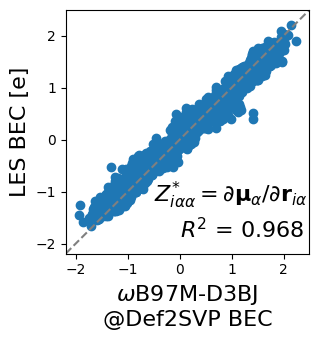

In [30]:
def get_diag(arr,diag=True):
    arr = torch.tensor(arr)
    mask = torch.zeros_like(arr)
    mv = torch.diagonal(mask,dim1=1,dim2=2)
    mv += 1
    if diag:
        return arr[mask.bool()].numpy()
    else:
        return arr[~mask.bool()].numpy()

import scipy
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
diag = True
truex = get_diag(obj.true_bec,diag=diag)
predx = get_diag(obj.pred_bec,diag=diag)
xmin = min(np.min(truex),np.min(predx)) - 0.25
xmax = max(np.max(truex),np.max(predx)) + 0.25
arr = np.arange(xmin,xmax,0.01)
r = scipy.stats.pearsonr(truex.ravel(),predx.ravel())[0]
r2 = np.round(r**2,3)
plt.xlabel("$\omega$B97M-D3BJ\n@Def2SVP BEC",fontsize=fs,**djvfont)
plt.ylabel("LES BEC [e]",fontsize=fs,**djvfont)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.scatter(truex,predx)
plt.plot(arr,arr,linestyle="--",color="grey")
plt.text(-0.5,-1.2,"$Z_{i \\alpha \\alpha}^{*} = \partial \mathbf{\mu}_\\alpha/\partial{\mathbf{r}_{i\\alpha}}$",fontsize=fs,**djvfont)
plt.text(0,-1.9,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/diagonal_bec.png",dpi=500)

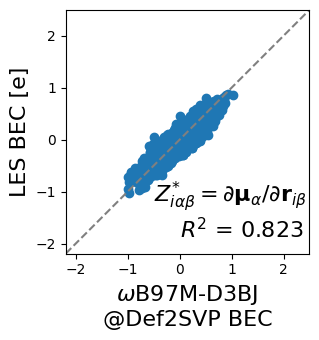

In [31]:
import scipy
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.subplots(figsize=(4,3.5))
diag = False
truex = get_diag(obj.true_bec,diag=diag)
predx = get_diag(obj.pred_bec,diag=diag)
xmin = -2.190323031838511
xmax = 2.49442159708481
arr = np.arange(xmin,xmax,0.01)
r = scipy.stats.pearsonr(truex.ravel(),predx.ravel())[0]
r2 = np.round(r**2,3)
plt.xlabel("$\omega$B97M-D3BJ\n@Def2SVP BEC",fontsize=fs,**djvfont)
plt.ylabel("LES BEC [e]",fontsize=fs,**djvfont)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.scatter(truex,predx)
plt.plot(arr,arr,linestyle="--",color="grey")
plt.text(-0.5,-1.2,"$Z_{i \\alpha \\beta}^{*} = \partial \mathbf{\mu}_\\alpha/\partial{\mathbf{r}_{i\\beta}}$",fontsize=fs,**djvfont)
plt.text(0,-1.9,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/nondiagonal_bec.png",dpi=500)